In [22]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
import math
import numpy as np
import json
from copy import deepcopy
import bisect

from config import filename, n_cores
print(filename)

data/smallRandom.json


In [24]:

def n2letter(n):
    '''0 to 'a', 1 to 'b', ... '''
    return chr(96+n)

def string2duration(string):
    ''' "01:50:19.3177493" to duration in seconds'''
    return 3600*int(string[:2]) + 60*int(string[3:5]) + int(string[6:8])  #Duration is int

In [25]:
def read_data(path):
    global task_count
    global tasks
    file = open(path)
    data = json.load(file)
    nodes = data['nodes']
    tasks = dict()
    for task_str, info in nodes.items():
        task = int(task_str)
        tasks[task] = {'Data' : string2duration(info['Data']), 'Dependencies' : info['Dependencies']}
    task_count = len(tasks)
    print("Data loaded successfully. Number of tasks: " + str(task_count))

read_data(filename)
tasks

Data loaded successfully. Number of tasks: 10


{1: {'Data': 2843, 'Dependencies': []},
 2: {'Data': 3656, 'Dependencies': [1]},
 3: {'Data': 2741, 'Dependencies': [1]},
 4: {'Data': 4166, 'Dependencies': [1]},
 5: {'Data': 5065, 'Dependencies': [2]},
 6: {'Data': 5116, 'Dependencies': [4]},
 7: {'Data': 3878, 'Dependencies': [2]},
 8: {'Data': 3596, 'Dependencies': [5]},
 9: {'Data': 5252, 'Dependencies': [7]},
 10: {'Data': 2883, 'Dependencies': [8]}}

In [26]:
#Tasks to child tasks / Tasks to parents / Task is terminal / Task is inital
task2childs = {task : list() for task in tasks}
task2parents = {task : list() for task in tasks}
for task, info in tasks.items():
    #Add childs
    list_task_parents = info['Dependencies']
    for task_parent in list_task_parents:
        task2childs[task_parent].append(task)
    #Add parents
    task2parents[task] = tasks[task]['Dependencies']
    
def task_is_terminal(task: int):
    return len(task2childs[task]) == 0
def task_is_inital(task: int):
    return len(task2parents[task]) == 0

print(task2childs)
print(task2parents)

{1: [2, 3, 4], 2: [5, 7], 3: [], 4: [6], 5: [8], 6: [], 7: [9], 8: [10], 9: [], 10: []}
{1: [], 2: [1], 3: [1], 4: [1], 5: [2], 6: [4], 7: [2], 8: [5], 9: [7], 10: [8]}


In [27]:
task2sbl = {}

def save_static_bottom_level(task : int):
    task_duration = tasks[task]["Data"]
    if task_is_terminal(task):
        sbl = task_duration
    else:
        list_sbl_child = list()
        for task_child in task2childs[task]:
            if task_child in task2sbl:
                sbl_child = task2sbl[task_child]
            else:
                sbl_child = save_static_bottom_level(task_child)
            list_sbl_child.append(sbl_child)
        sbl = max(list_sbl_child) + task_duration
                
    task2sbl[task] = sbl
    return sbl

for task in tasks:
    if task_is_inital(task):
        save_static_bottom_level(task)
        
task2sbl



{10: 2883,
 8: 6479,
 5: 11544,
 9: 5252,
 7: 9130,
 2: 15200,
 3: 2741,
 6: 5116,
 4: 9282,
 1: 18043}

In [28]:
class Graph:
    
    def __init__(self):
        self.tasks = tasks
        self.tasks_to_sbl = task2sbl
        self.tasks_to_parent = task2parents
        self.tasks_to_child = task2childs
        self.n_cores = 2
        self.nodes = list()

graph = Graph()

In [29]:
class Node():
    graph = graph
    
    def __init__(self, parent = None, task_to_add = None, core_where_to_add = None, time_task_start = None):
        '''Create a Node object ie a partial scheduling
        parent = parent Node, None if root
        task_to_add : task added to the partial schedule
        core_where_to_add : core where to do task
        time_task_start : instant where the core will start computing the task
        '''        
        if parent is None:
            self.parent = None
            self.tasks_done_time = dict()
            self.cores = {core_n : {"task" : -1, "task_end_time" : 0} for core_n in range(n_cores)}
            
            self.g = 0
            self.f = self.h()
                   
            self.hist = ''  
            self.schedule = dict()
            
        else:
            task_end_time = time_task_start + self.graph.tasks[task_to_add]['Data']
            
            self.parent = parent
            self.tasks_done_time = parent.tasks_done_time.copy()
            self.tasks_done_time[task_to_add] = task_end_time

            self.cores = parent.cores.copy()
            self.cores[core_where_to_add] = {"task" : task_to_add, "task_end_time" : task_end_time}
                
            self.g = max(parent.g, task_end_time)
            # self.f = max(self.g + self.h(), parent.f)
            self.f = self.g + self.h()
            
            self.schedule = parent.schedule.copy()
            self.schedule[task_to_add] = (time_task_start, task_end_time, core_where_to_add)
            self.hist = parent.hist + f"|Task {task_to_add} start at time {time_task_start} on core {core_where_to_add} "
                 
    def __repr__(self):
        string = '[' + ','.join([n2letter(task) for task in self.tasks_done_time]) + ']'
        string += ''.join([f"({core['task']} end at {core['task_end_time']})" for core in self.cores.values()])
        return string
            
    def is_goal(self):
        '''Return whether a node is a full schedule'''
        return len(self.tasks_done_time) == task_count
    
    def successors(self):                     
        '''Create and return list of child node of self'''
        childs = list()
        
        #On regarde toutes les tâches qu'on va tenter de rajouter
        for task, info in self.graph.tasks.items():
            
            #On passe les taches déjà ajoutées
            if task in self.tasks_done_time: 
                continue
            
            #On ne garde que les taches dont toutes les dépendances ont été réalisées
            if not all([task_required in self.tasks_done_time for task_required in info['Dependencies']]): 
                continue
            
            #On calcul le temps ou toutes les dépendances de task seront terminés par les coeurs   
            time_all_tasks_done = max([0] + [self.tasks_done_time[task_required] for task_required in info['Dependencies']])
                                         
            for core_n, core in self.cores.items():
                #On ne commence à faire la task que lorsque toutes les dépendances sont calculées et que le core est disponible.
                time_core_available = core["task_end_time"]
                time_task_start = max(time_all_tasks_done, time_core_available)
                
                child = Node(parent = self, task_to_add=task, core_where_to_add=core_n, time_task_start=time_task_start)    
                childs.append(child)
                
        return sorted(childs, key = lambda node: node.f)
        
    def cost(self, child_node):
        '''Return the cost of going from self to child_node, a child node of self
        '''
        res = child_node.g - self.g
        if res < 0:
            raise Exception("Cost difference is negative")
        return res
    
    def h(self):
        '''Estimated remaining time of the node-schedule for reaching a terminal node. Must understimate true value.
        '''
        successor_tasks = list()
        for task, info in self.graph.tasks.items():
            if task in self.tasks_done_time: #On passe les taches déjà ajoutées
                continue
            if not all([task_required in self.tasks_done_time for task_required in info['Dependencies']]):   #On ne garde que les taches dont toutes les dépendances ont été réalisées
                continue
            successor_tasks.append(task)
        if len(successor_tasks) == 0:
            return 0
        return max([self.graph.tasks_to_sbl[task] for task in successor_tasks])
        
    
    #Node-schedule method
    def __lt__(self, node):
        return self.f < node.f
    
    def __hash__(self):
        return int(self.f)
        
    def __eq__(self, node):
        '''Return whether a node is equal to another. Two nodes are considered equal if they have completed the same tasks and if all their cores stop working at same time.
        '''
        if self.g != node.g:
            return False       
        if self.tasks_done_time != node.tasks_done_time:
            return False
        return self.set_of_core() == node.set_of_core()
        
    def set_of_core(self):
        return set([core["task_end_time"] for core in self.cores.values()])
    
    def compute_g(self):
        return max([core["task_end_time"] for core in self.cores.values()])
    
# r = Node()
# x,y = r.successors()
# a,b,c,d,e,f, *_ = x.successors()
# g, h, i, j, k, l, *_ = y.successors()

# #Test successors
# print(a, b, c, d, e, f, sep = '\n')
# print()
# print(g, h, i, j, k, l, sep = '\n')
# print()

# #Test __eq__
# for i in (g, h, i, j, k, l):
#     for j in (a, b, c, d, e, f):
#         if i == j:
#             print(i, j)

# #Test cost
# x.cost(a)

#Test h
# print(r.h())
# print(x.h())



In [30]:
import time
import queue
import random as rd
import sys

def rdraise(x = 0.1):
    if rd.random() < x:
        raise

class IDA_star():
    def __init__(self, root, graph):
        self.root = root
        self.graph = graph

    def find_best_path(self):
        self.solution_found = False
        bound = self.root.h()
        self.path = [self.root]
        while len(self.path) > 0:
            found, score = self.search(bound)
            if found:
                return self.path[-1]
            bound = score
        raise Exception("No path from root to a terminal node")
            
    def search(self, bound):
        '''Search for the fastest way to a terminal node starting to the last node in the path (ie current node)
        bound : f-score maximal for keep searching in a branch. If the f-score of a node is inferior to bound, it means bound < f < f_real so the node is the solution.
        return : a tuple (FOUND, F_SCORE)
            FOUND : whether we have found the terminal node which is the solution
            F_SCORE : the true F_SCORE
        '''
        #Select current node
        node = self.path[-1]
        #If the f score exceeds the threshold, we cut down the exploration branch by returning this bad f score.
        if node.f > bound:         
            return False, node.f
        #If we reach the goal, it means f_score <= f_score_any_brothers (because node.successors() is sorted) and f_score <= f_score_any_nodes (by construction) so it is the solution
        if node.is_goal():
            return True, node.f
        #We explore the successors of node in order to return the best node
        mini = float('inf')    
        successors = node.successors()
        for succ in successors:
            self.path.append(succ)
            found, score = self.search(bound)
            #We found the solution so we just return True recursively. The solution is the self.path
            if found:
                #A terminal node was found but we take its best brother in terms of f score
                best_node = sorted(self.path[-2].successors(), key = lambda node : node.g + node.h())[0]
                self.path[-1] = best_node
                return True, score
            if score < mini:
                mini = score
            self.path.pop()
        return False, mini
            
    
fn = IDA_star(root = Node(), graph=graph).find_best_path()

[a,b,c,d,e,g,f,h,i,j](10 end at 18043)(9 end at 15629)(6 end at 12125)


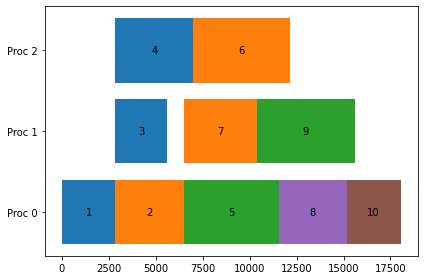

In [31]:
from collections import defaultdict
from itertools import cycle
from typing import Dict, Tuple
import matplotlib.pyplot as plt
import random

def cycle(lst: list[str]) -> str:
    x = lst.pop(0)
    lst.append(x)
    return x

def plot_schedule(node, critical_path=[]) -> None:
    schedule = node.schedule
    colors_by_proc = defaultdict(lambda:
        ['tab:blue', 'tab:orange', 'tab:green', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'])
    for id, (start, end, proc) in schedule.items():
        # cycle through the colors for this processor
        color = cycle(colors_by_proc[proc])
        colors_by_proc[proc].append(color)
        
        # handle critical path nodes
        if id in critical_path:
            critical_kwargs = {
                'edgecolor': 'red',
                'lw': 2,
                'zorder': 100,
            }
        else:
            critical_kwargs = {}
        
        # blot the bar and text
        plt.broken_barh([(start, end-start)],
                        (proc-.4, .8),
                        facecolors=color,
                        **critical_kwargs)
        plt.annotate(str(id),
                        xy=((start+end)/2, proc),
                        ha='center',
                        va='center',
                        zorder=101)
    plt.yticks(list(colors_by_proc.keys()), [f'Proc {proc}' for proc in colors_by_proc.keys()])
    plt.tight_layout()

print(fn)
plot_schedule(fn)


In [32]:
p = fn.parent
p.successors()
p

[a,b,c,d,e,g,f,h,i](8 end at 15160)(9 end at 15629)(6 end at 12125)

In [33]:
import cProfile
import pstats

root = Node()
ida_star = IDA_star(root = root, graph=graph)

with cProfile.Profile() as pr:
    final_node = ida_star.find_best_path()

print(final_node)
stats = pstats.Stats(pr)
stats.sort_stats(pstats.SortKey.TIME)
stats.dump_stats(filename='profiling.prof')
stats.print_stats()

[a,b,c,d,e,g,f,h,i,j](10 end at 18043)(9 end at 15629)(6 end at 12125)
         41601 function calls (40451 primitive calls) in 0.040 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     1276    0.013    0.000    0.020    0.000 <ipython-input-29-da47963b1fd8>:85(h)
     1245    0.007    0.000    0.028    0.000 <ipython-input-29-da47963b1fd8>:4(__init__)
      136    0.005    0.000    0.036    0.000 <ipython-input-29-da47963b1fd8>:49(successors)
   1153/3    0.003    0.000    0.039    0.013 <ipython-input-30-bc48c949d841>:26(search)
     7231    0.002    0.000    0.002    0.000 <ipython-input-29-da47963b1fd8>:92(<listcomp>)
     8108    0.002    0.000    0.002    0.000 {built-in method builtins.all}
     4118    0.002    0.000    0.002    0.000 {built-in method builtins.max}
     6170    0.001    0.000    0.001    0.000 {method 'append' of 'list' objects}
     3735    0.001    0.000    0.001    0.000 {method 'copy' of 'dict'